# Continous Space Ground-State Variational Search for Bosonic systems with NetKet

## Gabriel Pescia (EPFL-CQSL)

13 September, 2023

In this Tutorial we will explore the capabilities of NetKet to study the ground-state of bosonic many-body quantum systems in continuous space. As a first step we will consider an easy problem of non-interacting harmonic oscillators in free, three dimensional space, to introduce and explain the moving parts needed to perform a VMC optimization. Subsequently a more challenging example of interacting bosons in one dimensions with periodic boundary conditions will be studied. 

Specifically, we will study the following two Hamiltonians: 

$$ 
\mathcal{H}= -\frac{1}{2m}\sum_i \nabla_{\mathbf{x}_i}^2 + \frac{1}{2}\sum_i |\mathbf{x}_i|^2
$$
and 
$$ 
\mathcal{H}= -\frac{1}{2m}\sum_i \nabla_{\mathbf{x}_i}^2 + \sum_{i<j} \exp\left[-\frac{1}{2}|\mathbf{r}_{ij}|^2\right]
$$
,where the first term represents the kinetic energy contribution of particles of mass $m$, and the second term is the potential (interaction) energy ($\mathbf{r}_{ij} = \mathbf{x}_i-\mathbf{x}_j$).

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment and install NetKet within: 

```bash
python3 -m venv netket
source netket/bin/activate
pip install --upgrade "netket>=3.2"
```

**If you are on Google Colab**, uncomment the following cell and run it to install the required packages.

In [1]:
#!pip install --upgrade netket

In [1]:
import netket as nk

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


You should also check that your version of netket is at least 3.1

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.4.3.dev171+g7bdf6a95.d20230619


## 1. Defining The Hilbert Space and Sampler

The first ingredient in defining our problem in NetKet, consists of defining the Hilbert Space to study. 
For continuous space systems, the Hilbert space takes information about the number of particles, the size of the system and the type of boundary conditions: open or periodic. The dimensionality of space is inferred from the size of the system.
The species of particles (bosonic or fermionic) is not relevant for the Hilbert space but only in defining the variational Ansatz (symmetric or antisymmetric).
In the following the Hilbert space for $N=10$ particles in open (infinite) space is defined.

In [3]:
import jax.numpy as jnp
N = 10

#10 particles in 3D space without periodic boundary conditions. The length of the L-tuple indicates the spatial dimension of space.
hi = nk.hilbert.Particle(N=N, L=(jnp.inf, jnp.inf, jnp.inf), pbc=False)

We can now expect random states in the Hilbert space, we just defined. For the above specifications the random state will consists of a vector of $N*d = 10*3$ numbers ($d$ number of spatial dimensions), representing the 10 3D positions of the particles under consideration.

In [4]:
import jax
state = hi.random_state(jax.random.PRNGKey(0), 1)
print(state.reshape(N, -1)) #make it more readible, -1 = number of spatial dimensions

[[-0.28371066  0.9368162  -1.0050073 ]
 [ 1.4165013   1.0543301   0.9108127 ]
 [-0.42656708  0.986188   -0.5575324 ]
 [ 0.01532502 -2.078568    0.5548371 ]
 [ 0.91423655  0.5744596   0.7227863 ]
 [ 0.12106175 -0.3237354   1.6234998 ]
 [ 0.24500391 -1.3809781  -0.6111237 ]
 [ 0.1403725   0.84100425 -1.0943578 ]
 [-1.077502   -1.1396457  -0.593338  ]
 [-0.15576515 -0.38321444 -1.1144515 ]]


Of course we are not particularily interested in random states of our Hilbert space, but we rather want to be able to sample from a probability distribution, defined in the Hilbert space. To do this, NetKet provides the so-called Metropolis-Hasting sampler. This sampler uses an initial state in the Hilbert space (e.g. a random state) and produces a new state according to a transtition rule. The new state is accepted (e.g. becomes the initial state for another update according to the transition rule) if its probability is high enough (the probability of the state is determined by the variational Ansatz, see later). While you can write your own transition rule, NetKet already implements a common transition rule, that often is sufficient to run a VMC optimization.
The transition rule is given by adding normally distributed noise to the initial state:
$$
\mathbf{X} = (\mathbf{x}_1,...,\mathbf{x}_N) \mapsto \mathbf{X} + \mathbf{\Delta} = (\mathbf{x}_1 + \mathbf{\delta}_1,...,\mathbf{x}_N +\mathbf{\delta}_N)
$$
,where $\mathbf{\delta}_i \sim \mathcal{N}(0,\sigma^2)$ and $\sigma$ is chosen by the user, dependent on the system under consideration.
To decorrelate samples, the sampler provides functionality to insert more substeps of the above rule (e.g. add Gaussian noise multiple times). You can also specify how many parallel chains of the above rule you want to run. In the following, we initialize the sampler, with $\sigma=0.1$, 16 parallel chains, with 32 substeps of the transition rule.

In [5]:
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.1, n_chains=16, n_sweeps=32)

## 2. Defining The Hamiltonian

Now that the Hilbert space is defined, we also have to specify the Hamiltonian the particles are subject to. As written above we will start with a simple example of non-interacting particles, confined by a harmonic potential e.g. a collection of harmonic oscillators. 
A Hamiltonian in continuous space usually consists of two parts: kinetic and potential energy. The form of the kinetic energy is always the same and only depends on the mass of the particles. NetKet provides a full implementation of the the kinetic energy. In the following we initialize the kinetic energy operator for particles of masses $m=1$ (one could also provide a tuple of different masses for each particle).

In [6]:
ekin = nk.operator.KineticEnergy(hi, mass=1.0)

The potential energy part changes when changing from one system to another and therefore needs to be implemented from scratch. In NetKet this amounts to writing a function that takes a single sample $\mathbf{X}$ and outputs a single number representing the potential energy of the given configuration. For a harmonic confinement we have: 
$$
\mathbf{X} \mapsto \frac{1}{2}\sum_i |\mathbf{x}_i|^2
$$
or in code (we leave away the factor of 1/2 and multiply it later):

In [7]:
def v(x):
    return jnp.linalg.norm(x) ** 2

To use this function as an operator, NetKet provides a potential energy operator:

In [8]:
pot = nk.operator.PotentialEnergy(hi, v)

All left to do to define the complete Hamiltonian, is combine the kinetic and potential energy operators into a single operator object (note the factor of 1/2 that was omitted in the above definition of the potential energy):

In [9]:
ha = ekin + 0.5 * pot

## 3. Exact Ansatz

The most important thing for every VMC simulation is the variational Ansatz to the problem. If the Ansatz is capable of representing the true ground-state, the VMC results will be significantly better compared to a poorly chosen Ansatz that cannot represent the ground-state. 
For the case of non-interacting harmonic oscillators we know exactly what the many-body ground-state looks like:
$$
\psi(\mathbf{X}) = \prod_i \exp\left[-\frac{1}{2} |\mathbf{x}_i|^2\right].
$$
with associated probability distribution $P(\mathbf{X}) = \prod_i \exp\left[-|\mathbf{x}_i|^2\right]$.
To provide some first experience with NetKet in continuous space, we first choose a variational parameterization that can exactly represent the above state:
$$
\psi(\mathbf{X}) = \exp\left[-\frac{1}{2} \mathbf{X}^T\Sigma^{-1}\mathbf{X}\right].
$$
which is the ground-state for $\Sigma^{-1} = -\mathbb{I}$.

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. 
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), including the above multivariate Gaussian Ansatz. For completeness the model definition is copied below (to make sure that $\Sigma^{-1}$ is a proper covariance matrix (positive definite), we parameterize it as $\Sigma^{-1} = T T^T$):

In [10]:
import flax.linen as nn
import jax.numpy as jnp

from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils import deprecate_dtype
from netket.utils.types import DType, Array, NNInitFunc

class Gaussian(nn.Module):
    r"""
    Multivariate Gaussian function with mean 0 and parametrised covariance matrix
    :math:`\Sigma_{ij}`.

    The wavefunction is given by the formula: :math:`\Psi(x) = \exp(\sum_{ij} x_i \Sigma_{ij} x_j)`.
    The (positive definite) :math:`\Sigma_{ij} = AA^T` matrix is stored as
    non-positive definite matrix A.
    """

    param_dtype: DType = jnp.float64
    """The dtype of the weights."""
    kernel_init: NNInitFunc = normal(stddev=1.0)
    """Initializer for the weights."""

    @nn.compact
    def __call__(self, x_in: Array):
        nv = x_in.shape[-1]

        kernel = self.param("kernel", self.kernel_init, (nv, nv), self.param_dtype)
        kernel = jnp.dot(kernel.T, kernel)

        kernel, x_in = promote_dtype(kernel, x_in, dtype=None)
        y = -0.5 * jnp.einsum("...i,ij,...j", x_in, kernel, x_in)

        return y

The model above gives instructions on how to initialize the variational parameters and evaluate the model. To use it in the context of the VMC optimization, NetKet provides the Monte-Carlo-sampled Variational State `netket.vqs.MCState`, which requires a sampler and a model from which to sample from. We also have to provide the number of samples from which expectation values of operators are computed, at each iteration of the VMC optimization.
In the following we construct the variational state from the multivariate Gaussian Ansatz above, using the Gaussian sampler to sample from it and we choose a total of 10000 samples per iteration.

In [12]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
Gauss = Gaussian()

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sa, Gauss, n_samples=10**4, n_discard_per_chain=100)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters

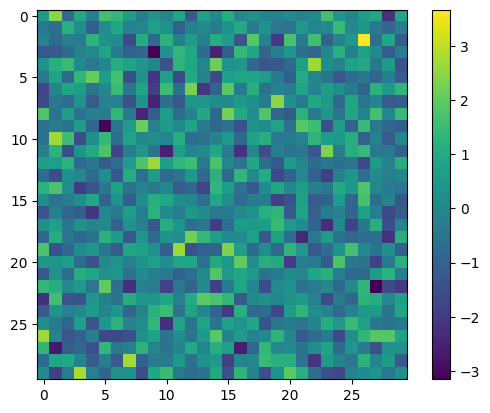

In [13]:
import matplotlib.pyplot as plt

# you can inspect the parameters which form a N*dxN*d matrix
plt.imshow(vstate.parameters['kernel'])
plt.colorbar()

In [14]:
# Expectation value: notice that it also provides an error estimate.
E = vstate.expect(ha)
print(E)

237.0 ± 1.8 [σ²=6751.0, R̂=1.0075]


In [15]:
# the energy (expectation value) is a structure with a lot of fields:
print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)



Mean                  : 236.96463359049122
Error                 : 1.7872113993224767
Variance              : 6750.965926151942
Convergence indicator : 1.0075157250409907
Correlation time      : 1.8656796825879254


In [16]:
vstate.expect_and_grad(ha)

(237.0 ± 1.8 [σ²=6751.0, R̂=1.0075],
 FrozenDict({
     kernel: Array([[ 0.26976868,  1.25210882,  0.24335274,  0.08090613, -0.20557206,
              1.60179439,  1.09276763, -0.55548402,  0.9230611 ,  0.29338964,
              1.16749565,  1.03538353, -0.69770493,  1.34773614, -0.16869114,
             -0.29395145,  0.23658292, -0.57500023,  0.17074176,  0.0264977 ,
             -0.63318461,  0.2591558 , -0.22538297,  0.56572065, -0.24944728,
              0.6843734 ,  0.45015386,  1.16081459, -0.55551881, -0.87155793],
            [-2.79252668, -0.97012124,  2.70863653, -0.57654631, -0.90816987,
              0.49291861,  3.37205826, -1.53583448,  2.42988745, -0.81948894,
             -1.76063675,  2.13601312, -3.85566634, -0.00678623,  0.03486243,
             -1.1681916 , -0.4532524 , -0.39903173,  0.97823953,  0.26821204,
             -0.9879186 ,  0.11947523, -1.01981825, -1.56799778, -2.63012502,
             -0.24982732,  1.07963763, -0.12605492, -0.3551896 ,  2.15283142],
   

## 4. Variational Monte Carlo

We will now try to optimise the covariance matrix $\Sigma^{-1}$ in order to best approximate the ground state of the hamiltonian, which has a ground-state energy of $\frac{1}{2}N*d=15$.

At first, we'll try to do this by ourself by writing the training loop, but then we'll switch to using a pre-made
solution provided by netket for simplicity.

### 4a. DIY Optimisation loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.

You can do so as follows:

In [17]:
from tqdm import tqdm

energy_history = []
n_steps = 150

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    vstate.sample()
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(ha)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_util.tree_map(lambda x,y: x-0.05*y, vstate.parameters, E_grad)
    # actually update the paramters
    vstate.parameters = new_pars

100%|█████████████████████████████████████████| 150/150 [00:44<00:00,  3.34it/s]


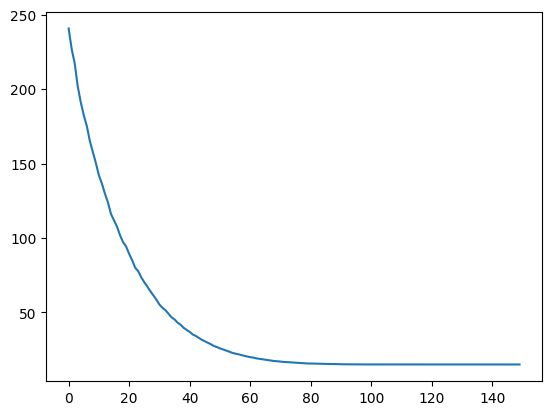

In [18]:
# We now can plot the energy during those optimisation steps:
import matplotlib.pyplot as plt

plt.plot(energy_history)

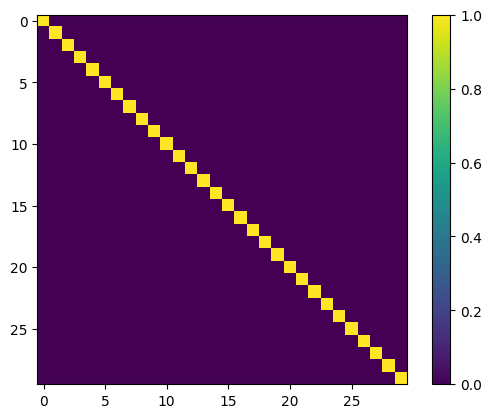

In [19]:
# as well as the resulting variational parameters, which indeed form the identity matrix now
kernel = vstate.parameters['kernel']
plt.imshow(jnp.dot(kernel.T, kernel))
plt.colorbar()

### 4b. Use NetKet's optimisation driver 

Of course NetKet provided functionality to do the above automatically:

In [20]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters(normal(stddev=1.0))

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(ha, optimizer, variational_state=vstate)

# run the driver for 150 iterations. This will display a progress bar
# by default.
gs.run(n_iter=150)

energy=vstate.expect(ha)
error = jnp.abs(energy.mean-15.)/15.
print("Optimized energy and relative error: ",energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|█| 150/150 [00:45<00:00,  3.30it/s, Energy=15.000021 ± 0.000030 [σ²=0.00000


Optimized energy and relative error:  15.000013 ± 0.000029 [σ²=0.000002, R̂=1.0047] 8.695687228055249e-07


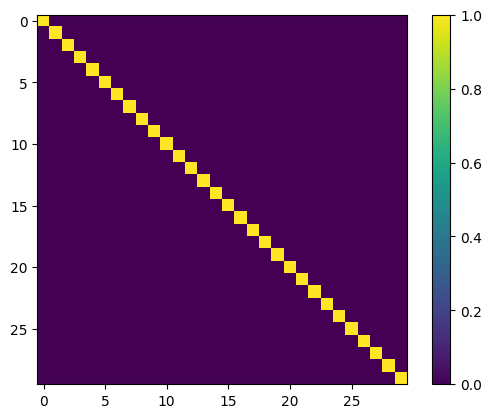

In [21]:
# we can again inspect the parameter:
kernel = vstate.parameters['kernel']
plt.imshow(jnp.dot(kernel.T, kernel))
plt.colorbar()

## 5. Neural-Network Quantum State 

Rarely do we know the functional form of the ground state wave-function. We therefore have to resort to highly flexible variational Ansaetze, capable of representing many different many-body states. We can for example use neural networks as universal function approximators. 
In the following, we use a neural network architecture called "DeepSets" to solve the more interesting case of bosons interacting via a repulsive Gaussian interaction:
$$
\epsilon  \sum_{i<j} \exp\left[-|\mathbf{r}_{ij}|^2\right].
$$
We study the bulk of the system by confining it into a box of length $L$ with periodic boundary conditions. In this extended system we define the particle density as $D = N/L^d$ and we study the case $D=1$ for $N=20$ particles in $d=1$ dimensions with $\epsilon = 2$. To account for the periodicity we use the minimum image convention when evaluating the potential energy of the system. For more information see: 

The DeepSets architecture we use is defined as:
$$
\mathrm{DS}(\mathbf{X}) = \rho\left[\sum_{i,j} \phi \left( \mathbf{y}_{ij}\right) \right]
$$
where the functions $\phi$ and $\rho$ are parameterized by simple feed-forward neural network with a GeLu activation function with one hidden layer.  To account for periodicity we choose as input $\mathbf{y}_{ij} = (\sin(\frac{2\pi}{L} \mathbf{r}_{ij}),  \cos(\frac{2\pi}{L} \mathbf{r}_{ij}))$.

See https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.4.023138 for more information.

First we define the Hilbert space, sampler and hamiltonian:

In [26]:
def minimum_distance(x, sdim):
   """Computes distances between particles using minimum image convention"""
   n_particles = x.shape[0] // sdim
   x = x.reshape(-1, sdim)

   distances = (-x[jnp.newaxis, :, :] + x[:, jnp.newaxis, :])[
       jnp.triu_indices(n_particles, 1)
   ]
   # minimum image convention 
   distances = jnp.remainder(distances + L / 2.0, L) - L / 2.0

   return jnp.linalg.norm(distances, axis=1)


def potential(x, epsilon, sdim):
   dis = minimum_distance(x, sdim)
   return epsilon * jnp.sum((jnp.exp(-(dis)**2)))


N = 20
D = 1.
dim = 1
epsilon = 2.
L = (N / D)**(1/dim)


hilb = nk.hilbert.Particle(N=N, L=(L,), pbc=True)
sa = nk.sampler.MetropolisGaussian(hilbert=hilb, sigma=0.4, n_chains=16, n_sweeps=10)


ekin = nk.operator.KineticEnergy(hilb, mass=1.0)
pot = nk.operator.PotentialEnergy(hilb, lambda x: potential(x, epsilon, dim))
ha = ekin + pot

In [30]:
class DS(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    L: float
    N: int
    sdim: int
    hidden_units : int = 8
      
    @nn.compact
    def __call__(self, x):
        x = x.reshape(-1,self.N, self.sdim)
        xij = x[...,None,:] - x[...,None,:,:]
        yij = jnp.concatenate((jnp.sin(2*jnp.pi/self.L * xij), jnp.cos(2*jnp.pi/self.L * xij)), axis=-1)
        
        ### PHI
        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        y = nn.Dense(features=self.hidden_units)(yij)
        # the non-linearity is a simple GeLu
        y = nn.gelu(y)
        # we apply the dense layer to the input
        y = nn.Dense(features=self.hidden_units)(y)
        # we sum over i,j
        y = jnp.sum(y, axis=(-3,-2))
        
        ### RHO
        # the function rho has a single output
        y = nn.Dense(features=self.hidden_units)(y)
        y = nn.gelu(y)
        y = nn.Dense(features=1)(y)
        return y.squeeze()
    
model = DS(L=L, N=N, sdim=dim)

vstate = nk.vqs.MCState(sa, model, n_samples=10**3, n_discard_per_chain=16)

We then proceed to the optimization as before. 

In [31]:
optimizer = nk.optimizer.Sgd(learning_rate=0.02)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(ha, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.05))

log=nk.logging.RuntimeLog()
gs.run(n_iter=200,out=log)

ds_energy=vstate.expect(ha)
error=abs((ds_energy.mean-24.742)/24.742)
print("Optimized energy and relative error: ",ds_energy,error)

100%|█| 200/200 [10:22<00:00,  3.11s/it, Energy=24.7447 ± 0.0079 [σ²=0.0637, R̂=


Optimized energy and relative error:  24.7372 ± 0.0082 [σ²=0.0671, R̂=1.0051] 0.00019299165698484892


## 6. Measuring Other Properties

Once the model has been optimized, we can of start to measure other observables than the energy as well. An interesting quantity could for example be the radial distribution function, which is related to the structure factor measured in scattering experiments. It is defined as:
$$
g(r) = C \langle \sum_{i<j} \delta(r-r_{ij}) \rangle
$$
where $\langle \cdot \rangle$ denotes the expectation value w.r.t. the probability distribution defined by the optimized wave-function. The constant $C$ is chosen such that $\int \mathrm{d}r g(r) = N*(N-1)$.

To evaluate the above expression we need samples from the optimized wave-function:

In [32]:
samples = vstate.sample(chain_length=3*10**4)

Then we compute the above observable by computing the distances $r_{ij}$ and computing a histogram of the result (the finer the histogram the closer we approximate the delta-distribution).

In [33]:
import numpy as np
import jax

def minimum_distance(x, sdim, N, L):
    """Computes distances between particles using mimimum image convention"""
    x = x.reshape(-1, N, sdim)
    
    idxs = jnp.triu_indices(N, 1)
    
    distances = (-x[...,jnp.newaxis, :, :] + x[...,:, jnp.newaxis, :])
    distances = distances[...,idxs[0],idxs[1],:]

    distances = jnp.remainder(distances + L / 2.0, L) - L / 2.0

    return jnp.linalg.norm(distances, axis=-1)


def gr(samples, n_particles, sdim, L, bins=80):
    dists = minimum_distance(samples, sdim, n_particles, L)
    
    hist, bin_edges = np.histogram(dists.flatten(), bins=bins, range=(0,L/2))    
    delta_r = bin_edges[1] - bin_edges[0]
    centers = (bin_edges[1:] + bin_edges[:-1])/2

    gC = hist / (dists.shape[0]*n_particles)

    def get_jacobian():
        if sdim == 1:
            return np.ones_like(centers) 
        elif sdim == 2:
            return 2*np.pi*centers
        elif sdim == 3:
            return 4*np.pi*centers**2
        else:
            raise NotImplementedError(f"Jacobian factor not yet implemented for sdim={sdim}")
    
    def get_volume():
        return L**sdim
    
    def get_density():
        return n_particles/get_volume()

    gU = get_jacobian()*delta_r*get_density()

    return centers, gC/gU

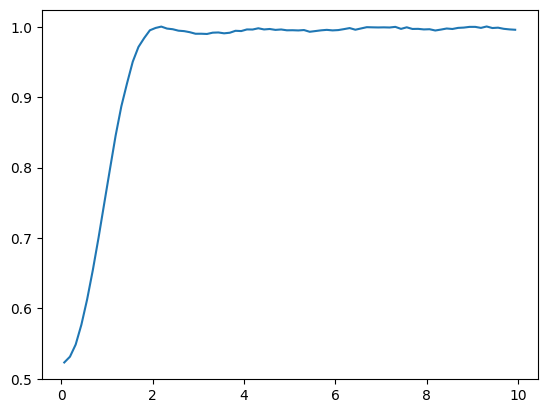

In [34]:
c, g = gr(samples, n_particles=N, sdim=dim, L=L)
plt.plot(c, g)

# Extra: $^4He$ in one dimension